In [1]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [2]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [3]:
N_YEARS = 50
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = '1978-07-26' #str(TODAY - timedelta(N_DAYS))
START, TODAY

('1978-07-26', datetime.date(2022, 2, 18))

In [4]:
SDS = 0.05 * (0.8 ** np.linspace(-4, 10, 7))
SD = SDS[TODAY.weekday()]
SD

0.015209558289982356

In [5]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ADSK', 'AMD', 'AMZN', 'ANET', 'APPH', 
    'AXON', 'BBY','BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD',
    'DDOG', 'DKNG', 'DOCU', 'DUOL', 'EDIT', 'ETSY', 'EVGO', 'FTCH',
    'FUV', 'FVRR', 'GH', 'GMED', 'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD',
    'LULU','MDB', 'MEDP', 'MELI', 'MNST', 'MSFT', 'MTCH', 'NVCR',
    'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW', 'PINS', 'PTON', 'QDEL',
    'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE', 'SHOP', 'SOLO', 'SPLK', 'SQ',
    'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO', 'TWLO', 'TWTR',
    'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA',  # NY Stock Exchange (total)
           '^W5000'] # Wilshire 5k
len(SYMBOLS)

72

In [6]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [7]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download()

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000


In [8]:
data['Date'].tail()

10983   2022-02-11
10984   2022-02-14
10985   2022-02-15
10986   2022-02-16
10987   2022-02-17
Name: Date, dtype: datetime64[ns]

In [9]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [10]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [11]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [12]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [13]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)

In [14]:
if TODAY.weekday() == 0:
    !say update standard deviation




----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 14.580938424912649
Refitting current best...
Current best ma returns: 16.202389287738725
Fraction Invested: 0.955625640619872
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 16.1911653831638
Invested: 0.955625640619872
New best: 16.191351673253763
Invested: 0.955625640619872
New best: 16.193876486037073
Invested: 0.955625640619872
New best: 16.204142609401863
Invested: 0.955625640619872
New best: 16.2075516253128
Invested: 0.955625640619872
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 14.580938424912649
Refitting current best...
Current best ew_ma returns: 17.85422382742942
Fraction Invested: 0.95872

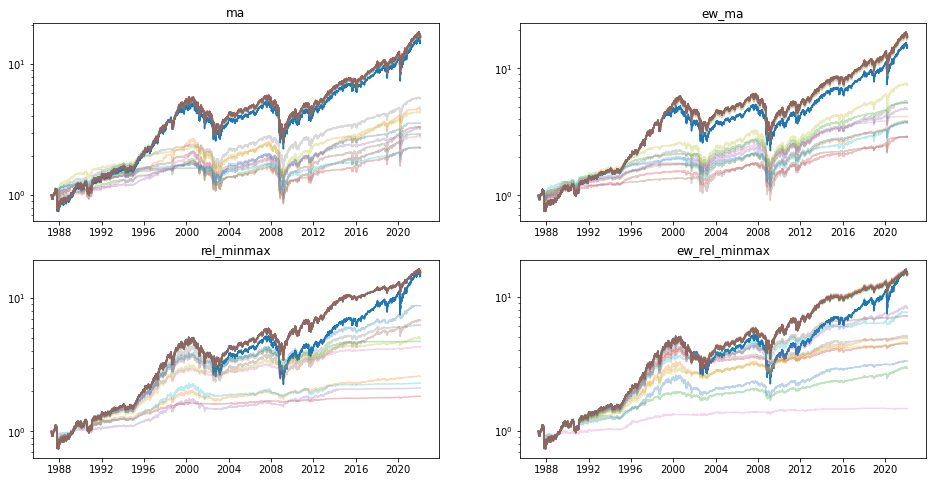

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 31.359668361692332
Refitting current best...
Current best ma returns: 40.733120262354376
Fraction Invested: 0.9972759998461759
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 40.73379691386444
Invested: 0.9972759998461759
New best: 40.73387901116747
Invested: 0.9972759998461759
New best: 37.05758709886923
Invested: 0.9972759998461759
New best: 37.05812243152293
Invested: 0.9972759998461759
New best: 37.058319360957455
Invested: 0.9972759998461759



Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 31.359668361692332
Refitting current best...
Current best ew_ma returns: 33.18311755475184
Fracti

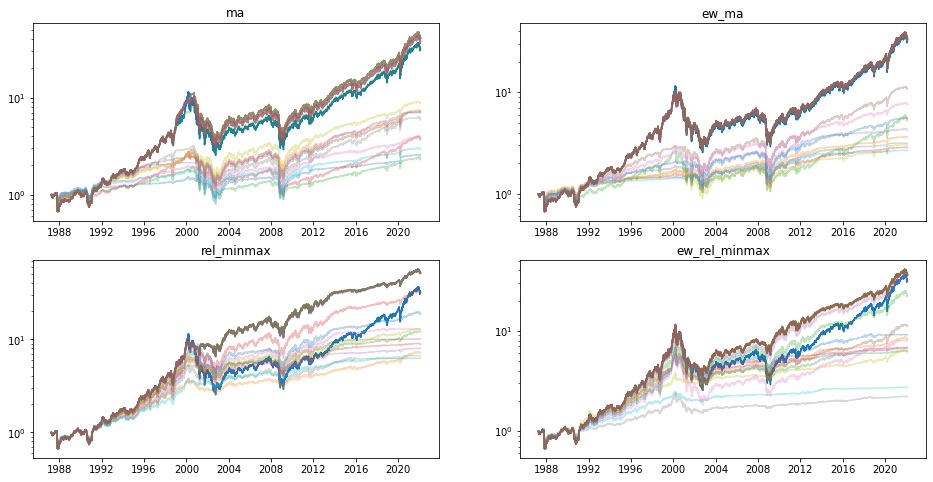

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 9.164030034322673
Refitting current best...
Current best ma returns: 11.367758960003481
Fraction Invested: 0.9999999637228756
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 11.367758906771336
Invested: 0.9999999637228756
New best: 11.397182693203899
Invested: 0.9999999637228756
New best: 11.397233189726833
Invested: 0.9999999637228756
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 9.164030034322673
Refitting current best...
Current best ew_ma returns: 9.759267765822836
Fraction Invested: 0.9992367717223863
Beginning random search...
Round: 10
Beginning adjusted search...
New best

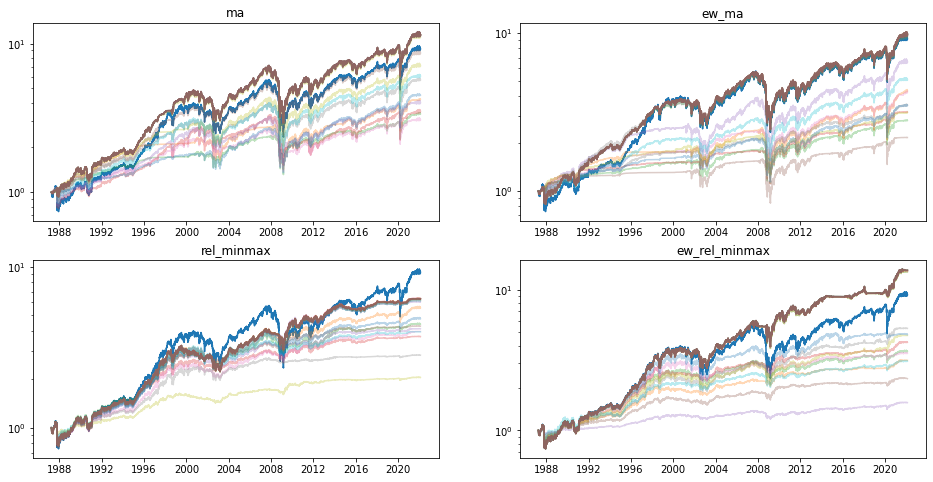

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.982693539831724
Refitting current best...
Current best ma returns: 8.21705476579906
Fraction Invested: 0.99557613909398
Beginning random search...
Round: 10
Beginning adjusted search...
New best: 8.217053778824468
Invested: 0.99557613909398
New best: 8.217100246116027
Invested: 0.99557613909398
New best: 8.217942522772756
Invested: 0.99557613909398
New best: 8.217961874698958
Invested: 0.99557613909398
New best: 8.217981178439787
Invested: 0.99557613909398
New best: 8.218006707087495
Invested: 0.99557613909398
Round: 15


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 7.982693539831724
Refitting current best...
Curre

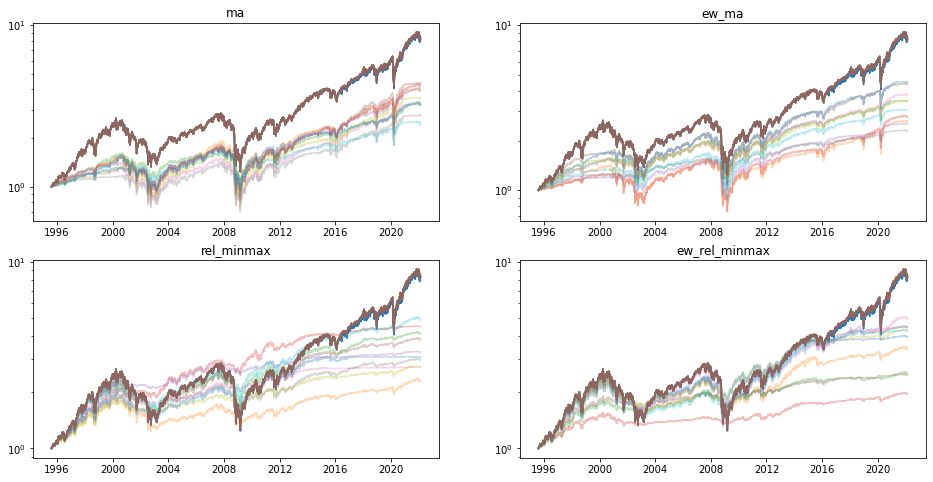

Saving ^W5000 params...


In [15]:
N_RAND = 10
N_ADJ = 15

for stock in batch:
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(stock_data, 
                      N_CUTS, 
                      best_param_set=best_params, 
                      best_returns=best_returns, 
                      sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [16]:
def get_summary(stocks):
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {100 * best_pct:.2f}% in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.3f} - {upper:.3f}): {pct:.3f}')
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue

In [17]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
get_summary(batch)


^GSPC:
  Best Return: 17.75796413267457 (ew_ma)
  95.87% in
time param: 1079
qs:
(0.000 - 0.525): 1.000
(0.525 - 0.646): 1.000
(0.646 - 0.655): 1.000
(0.655 - 0.668): 0.999
(0.668 - 0.671): 0.980
(0.671 - 0.770): 0.959
(0.770 - 0.963): 0.959
(0.963 - 0.971): 0.880
(0.971 - 0.980): 0.874
(0.980 - 1.000): 0.001

^IXIC:
  Best Return: 51.839591150211035 (rel_minmax)
  26.84% in
time param: 1079
qs:
(0.000 - 0.208): 1.000
(0.208 - 0.606): 1.000
(0.606 - 0.664): 1.000
(0.664 - 0.687): 0.999
(0.687 - 0.693): 0.964
(0.693 - 0.698): 0.963
(0.698 - 0.700): 0.868
(0.700 - 0.727): 0.593
(0.727 - 0.728): 0.588
(0.728 - 1.000): 0.268

^NYA:
  Best Return: 13.733087754576069 (ew_rel_minmax)
  0.94% in
time param: 360
qs:
(0.000 - 0.060): 0.989
(0.060 - 0.558): 0.988
(0.558 - 0.601): 0.981
(0.601 - 0.676): 0.967
(0.676 - 0.685): 0.952
(0.685 - 0.844): 0.852
(0.844 - 0.862): 0.677
(0.862 - 0.873): 0.396
(0.873 - 0.940): 0.170
(0.940 - 1.000): 0.009

^W5000:
  Best Return: 8.25754299447487 (rel_minmax

In [18]:
!say qp is dunzo

IXIC: Nasdaq